<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-dsercam/blob/main/RetoFinal/RetoFinal_Avance1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color="darkblue">Reto: Actividad Final</font>**
##**<font color="darkorange">  Regresiones y K means</font>**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Ciencia y analítica de datos**
####**Tecnológico de Monterrey**
#####**Prof: María de la Paz Rico Fernández**

###**<font color="darkgray">Nombre del estudiante: Dante Rodrigo Serna Camarillo</font>**
###**<font color="darkgray">Matrícula: A01182676</font>**


## Imports and installs

In [3]:

! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 42.2 MB/s 
     |████████████████████████████████| 1.0 MB 48.9 MB/s 
     |████████████████████████████████| 1.7 MB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 50.3 MB/s 
     |████████████████████████████████| 6.3 MB 51.7 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=8f519ef15afd007c141758d440057b33c7dafa3589fd4a2a602ec79c1e60ced6
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3a8da94dbae7125e8aaadaf1b1bcce9d2c6e61abe9422272431a71bf9ef60098
  Stored in directory: /root/.

In [5]:
import pandas as pd
import numpy as np
from shapely.geometry import Point # para definir cooredans que puedan ser usadas con geopy
import geopandas as gpd #para graficar en mapa
import matplotlib.pyplot as plt

## Carga de shape files para mexico

Obtenemos los shape files de Mexico, disponibles en un zip dentro del repo. Realizamos un unzip para cargar los datos en nuestro enterno de google colab.

In [11]:
!wget https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
!unzip /content/mapa_mexico.zip

--2022-11-11 00:51:19--  https://github.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/raw/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip [following]
--2022-11-11 00:51:19--  https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/mapa_mexico/mapa_mexico.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11342120 (11M) [application/zip]
Saving to: ‘mapa_mexico.zip.1’

mapa_mexico.zip.1   100%[===================>]  10.8

Leer el shape file con geopandas.

In [12]:
mx = gpd.read_file('mapa_mexico/')\
        .set_index('CLAVE')\
        .to_crs(epsg=4485)
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
CLAVE,,,,,,
02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-73565.018 3602427.487, -73564.403 3..."
02003,Tecate,Baja California,02,003,3670.991923,"POLYGON ((-38995.078 3617846.589, -31557.921 3..."
02002,Mexicali,Baja California,02,002,13119.275713,"POLYGON ((48160.716 3621731.593, 58570.990 362..."
02005,Playas de Rosarito,Baja California,02,005,517.120801,"POLYGON ((-70946.724 3594803.753, -70966.034 3..."
26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((127160.493 3587762.823, 127099.688 3..."


## Fetch de data sets

In [14]:
#Permalinks a nuestros CSVs
csvAguasSubterraneas  = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
csvAguasSuperficiales = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-dsercam/main/RetoFinal/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv"


In [15]:
#Config para ver todas las columnas de los dataframes
pd.set_option('display.max_columns', None)

In [17]:
#Fetch de datos
dfUnprocessedSubterraneas  = pd.read_csv(csvAguasSubterraneas, skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')
dfUnprocessedSuperficiales = pd.read_csv(csvAguasSuperficiales,  skipinitialspace=True, skip_blank_lines=True, encoding = 'cp1252')


In [18]:
print('--------'*10)
print("Dimensiones DataFrame aguas superficiales (sin procesar): ", dfUnprocessedSuperficiales.shape)
print("Dimensiones DataFrame aguas subterraneas (sin procesar): ", dfUnprocessedSubterraneas.shape)
print('--------'*10)

--------------------------------------------------------------------------------
Dimensiones DataFrame aguas superficiales (sin procesar):  (4141, 55)
Dimensiones DataFrame aguas subterraneas (sin procesar):  (1068, 57)
--------------------------------------------------------------------------------


## Preprocesamiento

In [19]:
print('Preview Aguas subterraneas:')
dfUnprocessedSubterraneas.head(5)

Preview Aguas subterraneas:


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CALIDAD_ALC,CONDUCT_mS/cm,CALIDAD_CONDUC,SDT_mg/L,SDT_M_mg/L,CALIDAD_SDT_ra,CALIDAD_SDT_salin,FLUORUROS_mg/L,CALIDAD_FLUO,DUR_mg/L,CALIDAD_DUR,COLI_FEC_NMP/100_mL,CALIDAD_COLI_FEC,N_NO3_mg/L,CALIDAD_N_NO3,AS_TOT_mg/L,CALIDAD_AS,CD_TOT_mg/L,CALIDAD_CD,CR_TOT_mg/L,CALIDAD_CR,HG_TOT_mg/L,CALIDAD_HG,PB_TOT_mg/L,CALIDAD_PB,MN_TOT_mg/L,CALIDAD_MN,FE_TOT_mg/L,CALIDAD_FE,SEMAFORO,CONTAMINANTES,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,Alta,940.0,Permisible para riego,NaN,603.6,Cultivos sensibles,Potable - Dulce,0.9766,Potable - Optima,213.732,Potable - Dura,<1.1,Potable - Excelente,4.184656,Potable - Excelente,0.0161,Apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,0.0891,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,Alta,608.0,Buena para riego,NaN,445.4,Excelente para riego,Potable - Dulce,0.9298,Potable - Optima,185.0514,Potable - Dura,<1.1,Potable - Excelente,5.75011,Potable - Buena calidad,0.0134,Apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,Alta,532.0,Buena para riego,NaN,342,Excelente para riego,Potable - Dulce,1.8045,Alta,120.719,Potable - Dura,<1.1,Potable - Excelente,1.449803,Potable - Excelente,0.037,No apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Rojo,"FLUO,AS,",SI,SI,SI,SI,NO,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,Alta,686.0,Buena para riego,NaN,478.6,Excelente para riego,Potable - Dulce,1.1229,Potable - Optima,199.879,Potable - Dura,<1.1,Potable - Excelente,1.258597,Potable - Excelente,0.0154,Apta como FAAP,<0.003,Potable - Excelente,0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,Alta,1841.0,Permisible para riego,NaN,1179,Cultivos con manejo especial,Ligeramente salobres,0.2343,Baja,476.9872,Potable - Dura,291,Aceptable,15.672251,No apta como FAAP,<0.01,Potable - Excelente,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Rojo,"NO3,",SI,SI,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [20]:
print('Preview Aguas Superficiales:')
dfUnprocessedSuperficiales.head(5)

Preview Aguas Superficiales:


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


### Construccion de data frames de longitud y latitud para graficar

In [21]:
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
superficialesLatLon = dfUnprocessedSuperficiales.copy()
superficialesLatLon = superficialesLatLon[['CLAVE','LATITUD','LONGITUD']]
superficialesLatLon["Coordinates"] = list(zip(superficialesLatLon.LONGITUD, superficialesLatLon.LATITUD))
superficialesLatLon["Coordinates"] = superficialesLatLon["Coordinates"].apply(Point)
#definimos nuestro dataframe de longitudes y latitudes para aguas superficiales
subterraneasLatLon = dfUnprocessedSubterraneas.copy()
subterraneasLatLon = subterraneasLatLon[['CLAVE','LATITUD','LONGITUD']]
subterraneasLatLon["Coordinates"] = list(zip(subterraneasLatLon.LONGITUD, subterraneasLatLon.LATITUD))
subterraneasLatLon["Coordinates"] = subterraneasLatLon["Coordinates"].apply(Point)

## <font color='red'>Definir componentes para grafica del pais</font>


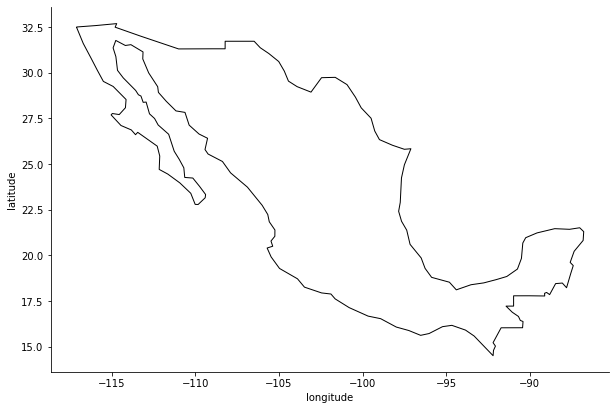

In [ ]:
#mapa
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
world.name.unique()

fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

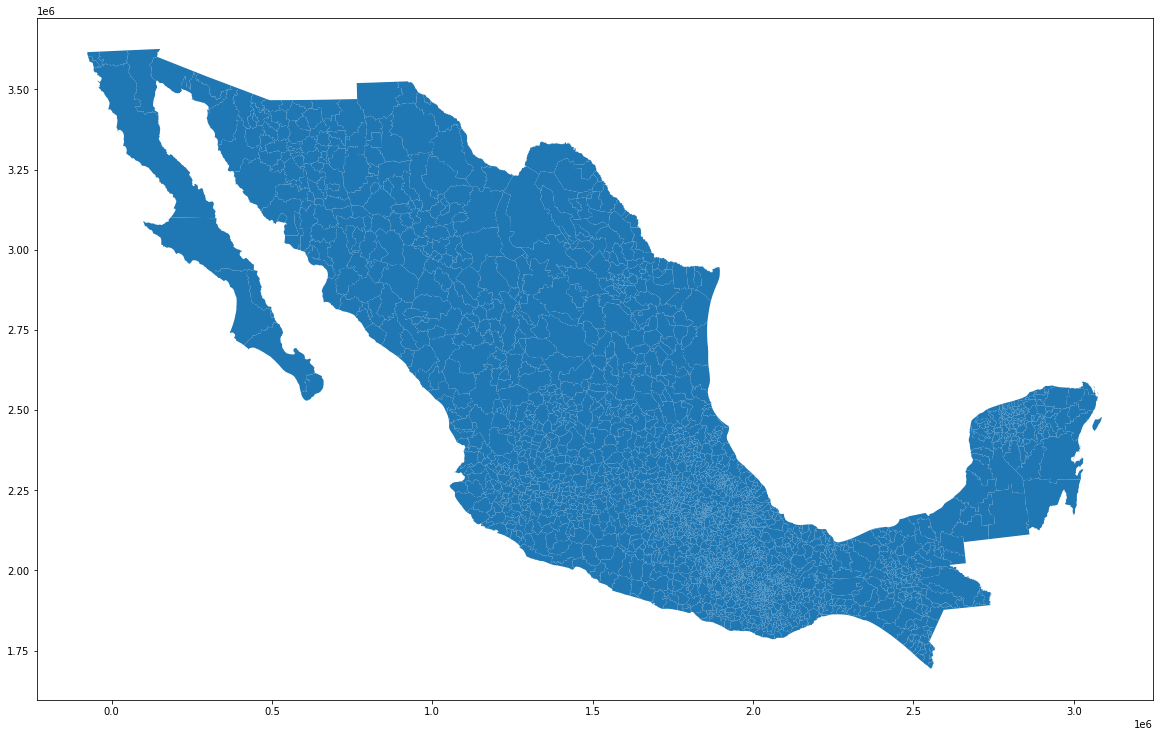

In [22]:
fig, ax = plt.subplots()
mx.plot( k=5, ax=ax)
fig.set_size_inches(20, 14)